In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm  #progress bar
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [ ]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(3)

: 

full_df.csv içerisindeki doktar teşhislerine göre "cataract" etkiketi ile etkitlenmiş verileri ayırmak için metodumuzu oluşturduk.

In [3]:
def kataraktli(text):
    if "cataract" in text:
        return 1
    else:
        return 0

CSV dosyasımızda sağ ve sol veri grupları için ayrı ayrı teşhisler verildiği için aynı metodu her iki grup içinde çağırıyoruz  çağırıyoruz. Çağırdığımız veri setlerini sağ ve sol katarakt şeklinde ayrı bir dataframe de tuttuk.Katarakt verileri veri setinde 'C' olarak  ve kataraklı hastaları 1, katarakt hastası olmayanlar 0 şeklinde tutulmuş. full_df.csv içerisindeki doktar teşhislerine göre "cataract" etkiketi ile etkitlenmiş verileri hem sağ hemde sol göz verileri için ayırıp çalıştırıyoruz.

In [4]:
df["sol_katarakt"] = df["Left-Diagnostic Keywords"].apply(lambda x: kataraktli(x))
df["sag_katarakt"] = df["Right-Diagnostic Keywords"].apply(lambda x: kataraktli(x))

In [5]:
sol_katarakt = df.loc[(df.C ==1) & (df.sol_katarakt == 1)]["Left-Fundus"].values
sol_katarakt[:10]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg'], dtype=object)

In [6]:
sag_katarakt = df.loc[(df.C ==1) & (df.sag_katarakt == 1)]["Right-Fundus"].values
sag_katarakt[:10]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg'], dtype=object)

Sağ ve sol gözdeki toplam kataraktlı göz sayısı.

In [7]:
print("Sol kataraktlı görsel sayısı: {}".format(len(sol_katarakt)))
print("Sağ kataraktlı görsel sayısı: {}".format(len(sag_katarakt)))

Sol kataraktlı görsel sayısı: 304
Soğ kataraktlı görsel sayısı: 290


Multiclass regresyon yapmak yerine sadece normal ve cataractlı göz hücreleri alınacağı için normal göz hücrelerinin de veri setinden çekilmesi. Veri setinde normal göz hücresinin verisi kataraktlı verilerden çok daha fazla olduğu için verinin dengesiz olmaması için normal göz hücresi için sağ ve sol göz için 250 sample alıyoruz.

In [8]:
sol_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"]== "normal fundus")]["Left-Fundus"].sample(250,random_state = 42).values
sag_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"]== "normal fundus")]["Right-Fundus"].sample(250,random_state = 42).values
sag_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

Sağ ve sol göz verisi olarak ayrılmış verileri sadece normal ve kataraktlı gözler için dataframe içerisinde birleştiriyoruz.

In [9]:
cataract = np.concatenate((sol_katarakt,sag_katarakt), axis = 0)
normal = np.concatenate((sol_normal,sag_normal), axis = 0)
print(len(cataract),len(normal))

594 500


Görsellerin directory'si üzerinden görsele erişip, kerasın preprocessing kütüphanesinden faydalanarak görsellerin numpy dizisi şeklinde formatlandırdık. dataset değişkeninde istediğimiz formatta verilerimiz ve o veriye ait etiketler bulunmakta.Etiketler ile path üzerindeki kataraktlı verileri joinledik.

In [10]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
gorsel_boyut = 224
labels = []
dataset = []
def veriseti_olustur(image_category,label):
    for img in tqdm(image_category):
        #gorsel ve veriyolunu joinleme islemi
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(gorsel_boyut,gorsel_boyut))
        except:
            continue
            
        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

Aynı işlemleri hem kataraktlı göz hücresi görselleri ve normal göz hücresi görselleri üzerinde veriseti_olustur metodunun çağırarak uyguladık.

In [11]:
dataset = veriseti_olustur(cataract,1)

100%|██████████| 594/594 [00:06<00:00, 94.31it/s] 


In [12]:
len(dataset)

588

In [13]:
dataset = veriseti_olustur(normal,0)

100%|██████████| 500/500 [00:07<00:00, 69.13it/s]


In [14]:
len(dataset)

1088

Rastgele olarak formatlanmış görsellerin gösterimi:

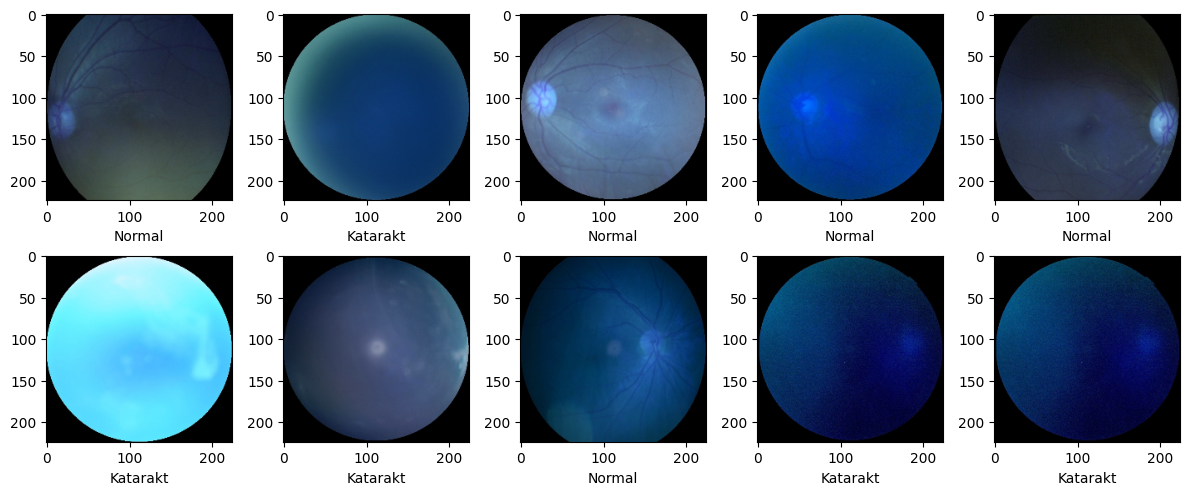

In [15]:
plt.figure(figsize=(12,5))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    gorsel = dataset[sample][0]
    category = dataset[sample][1]
    if category == 0:
        label = "Normal"
    else:
        label = "Katarakt"
    plt.subplot(2,5,i+1)
    plt.imshow(gorsel)
    plt.xlabel(label)
plt.tight_layout()
    

Veri setlerinin x(nicelik) ve y(hedef) olarak ayıralım.

In [16]:
#reshape params: uygun boyut,genislik,yukseklik, rgb
x = np.array([i[0] for i in dataset]).reshape(-1,gorsel_boyut,gorsel_boyut,3)
y = np.array([i[1] for i in dataset])

Nicelik ve hedeflerimizi kullanarak veri setini train(eğtim) ve test olarak ikiye ayıralım.

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

**Model Seçimi**:
Problemimiz görsel tanıma ve sınıflandırma problemi olduğu için ya kendimiz bir nueral network oluşturmalıyız ya da "state-of-the-art modelleri olarak bilinen derin öğrenme modellerini tercih etmeliyiz. Görsel tanıma ve sınıflandırma için bir çok model bulunmakta. Öncelikli amaç bu modellerden birkaç tanesinin veri setinde uygulanıp, veri setine en uygun modelin seçilmesi, ezberlemenin önüne geçilmesi ve seçilen model üzerindeki ince ayar(fine-tune) işlemlerinin gerçekleştirilmesidir. Veri setimizi farklı modeller ile eğittikten sonra performans ölçütleri(hata oranı, overfeeding,underfitting,hız, hafıza kullanımı vb) gibi niceliklerin tez sonunda sunulması planlanmaktadır.

****VGG19 Kullanarak Derin Öğrenme Yapısının Oluşturulması****

**TODO** VGG19 modelinin diyagram yapısı ve mimarinin açıklanması.

Önceden eğitilmiş veri setinin import edilmesi.

In [18]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(gorsel_boyut,gorsel_boyut,3))

80134624/80134624 [==============================] - 1s 0us/step


VGG'nin derin öğrenme modelindeki katmanları başlangıçta eğitilemez olarak set ediyoruz. Bunun temel sebebi VGG19 modelinin önceden eğitilmiş ağırlıkları ImageNet gibi büyük bir veri seti üzerinden eğitildiği için (pre-trained data) önceden öğrenilmiş özelliklerin korunması ve üzerine eklenen yeni sınıflandırma katmanlarının daha spesifik veri setine uygun hale getirilmesi amaçlanır. Yani özetle amacımız; modelin önceden eğitilmiş ağırlıkları korunması ve yalnızca eklenen yeni sınıflandırma katmanlarının genel özellikleri kullanarak eğitilmesidir. Bu, genellikle fine-tuning işleminin ilk adımıdır ve daha sonra eklenen katmanlarla birlikte model eğitilir.

In [19]:
for layer in vgg.layers:
    layer.trainable = False

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid")) #cikti birim,aktivasyon(0-1)secim ikili

VGG modelinin katmanları, flatten katmanı,ve dense katmanlarını import ettik ve bir neural network yapısı oluşturduk.Flatten katmanı çok boyutlu giriş verilerini tek boyutlu vektörlere dönüştürerek sinir ağının ardışık katmanlarında işlenebilmesini sağlayan bir yapıdır. Bizim çalışmamızda 3 boyutlu(yükseklik,genişlik,RGB) tensor olarak algılanan renkli görsellerin işlenmesi gerekmektedir.Dense(yoğunluk) katmanı: katmanlar arasında tam bağlantılı bir yapı oluşturup sinir ağında  girdi verilerini çıktı verilerine dönüştürür. Aktivasyon fonksiyonu olarak sigmoid seçmemizdeki sebep sınıflandırmamızın ikili sınıflandırma olmasıdır. Sigmoid fonksiyonu çıktıyı 0-1 aralıında bir olasıllık değerine dönüştürür, 0.5'i eşik değeri olarak seçer ve karşılaştırma yapar. Özetle ikili sınıflandırma için ideal bir aktivasyon fonksiyonudur. Çalışmanın devamında hiperparametrelerin en iyilenmesi kısmında değiştirilebilir.


**TODO** Sigmoid Fonksiyonun Grafiğinin konulması.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


summary() metoduyla katmanlardaki patamatreleri gösterdik. 

In [22]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

Oluşturduğumuz sinir ağı yapısını compile ettik. İlk parametre olan adam (Adaptive Moment Estimation) optimezerı loss değerimizi minimize etmeyi sağlar. Çalışma prensibi olarak adaptif öğrenme hızı, momentum (dalgalanma) düzenleme ve hafıza işlemlerini efektif olarak yapar. Çalıştığımız veri seti gibi verilerin çok boyutlu ve çok sayıda veri barındıran veri setlerinde ideal çalışma imkanı sunar.
Loss parametresi metodun gerçek değeri ile tahmin edilen değer arasındaki farkın hangi metotla yapılacağını belirler. Bizim örneğimizde "binary_crossentropy" kullanıldı. Bunun en temel sebebi multiclass regresyon/multiclass sınıflandırma yerine Katarakt ya da Normal sınıflandırma yapmamızdır. Kayıp fonksiyonun metriği ise "accuracy" olarak verdik. Gerçek tahmin ile tahmin edilen arasındaki farklı bulmak istiyoruz. Alternatif olarak f1-score, precission ve recall gibi parametrelerde verilebilirdi.


**Parametrelerin En İyilenmesi (Fine Tuning)**

Elimizdeki derin öğrenme modelinin parametrelerinin en iyilenmesi için öncellikle olarak **Model Checkpoint** ve **Early Stopping ** metotlarının açıklanmasıyla ve modele uygun set edilmesiyle başlayacağız. 
Model Checkpoint: Tensorflow'un resmi dökümantayonuna göre modelcheckpoint metodolojisi, eğitim süreci sırasında ve sonrasında modelin ilerlemesini ve son durumu kaydetmek için kullanılan bir mekanizmadır, temelde 3 konsepti vardır. Bunlar eğitim sürecinin devam ettirilmesi, model performasının farklı eğitim süreçlerinde değerlendirilmesi ve model paylaşımı. Kendi örneğimizde model performansını değerlendirilirken en iyi sonucu veren kontrol noktasını; ağırlıkları VGG19 ağırlıklarına sahip ve daha isabetli sonuçların öncelikli olacağı şekilde set edeceğiz.
Prechelt, L. 'in kitabındaki tanımda ise Early stopping, aşırı öğrenme (overfitting) problemini çözmek için kullanılan bir tekniktir. Eğitim süreci sırasında modelin performansı sürekli olarak izlenir ve belirli bir sayıda ardışık epoch boyunca doğrulama veri kümesinde performansta bir iyileşme olmadığı durumlarda eğitim durdurulur. Bu, modelin genelleştirme yeteneğini artırır ve gereksiz hesaplama kaynaklarını kullanmamızı engeller.
Bizim modelimizde modelin isabeti üzerinden bir Early Stopping işlemi gerçekleştireceğiz.
Kaynak: Prechelt, L. (1998). Early stopping - but when? In Neural Networks: Tricks of the Trade (pp. 55-69). Springer. <-- Erken durma kaynak

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

Verilerimizi monitör ederken accuracy değeri yerine validation accuracy(çoğu kaynakta overall accuracy olarak geçer) değerine göre yapmamızın sebebi modelin train veri setinde ezberleme yapıp yapmadığını kontrol etmektir. Yüksek accuracy değerine sahip olsak bile modelimiz veriyi ezberliyorsa(test de efektif çalışmıyorsa) model yüksek başarıma sahip olduğu söylenemez. Set edilen ölçeklerde model eğitimi yapılır. Her bir epohun isabet oranı ve kayıplarını ekrana yazdırırsak:

In [24]:
history = model.fit(x_train,y_train,batch_size=32,epochs=25,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/25
28/28 [==============================] - 29s 423ms/step - loss: 1.5185 - accuracy: 0.8908 - val_loss: 0.9576 - val_accuracy: 0.9312
Epoch 2/25
28/28 [==============================] - 5s 185ms/step - loss: 0.2971 - accuracy: 0.9678 - val_loss: 0.4157 - val_accuracy: 0.9450
Epoch 3/25
28/28 [==============================] - 5s 186ms/step - loss: 0.0676 - accuracy: 0.9897 - val_loss: 0.4594 - val_accuracy: 0.9633
Epoch 4/25
28/28 [==============================] - 5s 175ms/step - loss: 0.0116 - accuracy: 0.9943 - val_loss: 0.4429 - val_accuracy: 0.9495
Epoch 5/25
28/28 [==============================] - 5s 187ms/step - loss: 0.0069 - accuracy: 0.9966 - val_loss: 0.3738 - val_accuracy: 0.9495
Epoch 6/25
28/28 [==============================] - 5s 187ms/step - loss: 0.0238 - accuracy: 0.9908 - val_loss: 0.5775 - val_accuracy: 0.9587
Epoch 7/25
28/28 [==============================] - 5s 187ms/step - loss: 0.1308 - accuracy: 0.9736 - val_loss: 0.5521 - val_accuracy: 0.9679
Epoch

Bu çıktıya göre başlangıçta 1.2487   olan hata oranı 4.6007e-06 'e kadar düştü. patience=5 ifadesiyle 5 epoch boyunca accuracy değerinde ilerleme kaydedilmezse eğitim durduruldu.

In [25]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 151ms/step - loss: 0.6002 - accuracy: 0.9633
loss: 0.6001932621002197
Accuracy: 0.963302731513977


Loss ve accuracy değerlerini evaluate metodunu kullanarak tahmin işlemi yaptık. Evaluate  metodu performans değerlendirme işleminde loss ve accuracy değişkenlerini hesaplamak için kullanılınır. Predict ise performans ölçmek yerine modelin son durumdaki girişlerine karşılık gelen çıktıyı verir. Şu an modelimiz yüksek 4.6007e-06  ve düşük loss değerine sahip ve bu bizim için ideadl fakat oluşturduğumuz modelin performansını ölçmek için konfüzyon matrisi ve accuarcy score gibi metriklerle de kontrol etmemiz gerekir.

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)
y_pred = (model.predict(x_test) > 0.5).astype("int32")

7/7 [==============================] - 1s 149ms/step


20. cellde de belirtildiği üzere ikili sınıflandırma yapılacağı için normal ve kataraktlı göz hücreleri 0.5 eşik değeri ile predict edilir.

In [27]:
accuracy_score(y_test,y_pred)

0.963302752293578

Modelimiz 0.96 isabet oranıyla verileri doğru tahmin ediyor. Test veri setinde tahmin edilen değerlerin sınıflandırma raporları aşağıdaki gibidir.

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       103
           1       0.95      0.98      0.97       115

    accuracy                           0.96       218
   macro avg       0.96      0.96      0.96       218
weighted avg       0.96      0.96      0.96       218



Modelimizdeki performans metriklerini incelediğimizde ortalama 0.97 precesion(kesinlik) tahminleri yapıyor. Yani pozitif olarak tahmin edilen örneklerin toplam örneklere oranını veriyor.Precision = True Positive / (True Positive + False Positive). Recall(duyarlılık) değeri gerçek pozitiflerin ne kadarının doğru tahmin edildiğini veriyor. F1- score precesion ve recall değerlerinin doğruluğunu, support sınıfı ise belirli sınıfa ait gerçek etiketlere sahip örneklerin sayısını gösteriyor. Bizim raporumuzda bu oranların hepsinin yüksek olduğunu görebiliyoruz.

İstatistiksel sınıflandırmada, verileri belirli bir sınıf kümesine tahmin etmek veya sınıflandırmak için algoritmalar veya modeller oluştururuz. Modeller mükemmel olmadığından dolayı, bazı veri noktaları yanlış şekilde sınıflandırılacaktır. Konfüzyon matrisi, modelin ne kadar iyi performans gösterdiğini gösteren bir tablo özeti olarak kullanılır. Kaynak -->https://devopedia.org/confusion-matrix
Test veri setinde konfüzyon matrisimizi çizdirerek hangi örneklerde hatalı hangi örneklerde başarılı tahminler yaptığımızı görebiliriz.
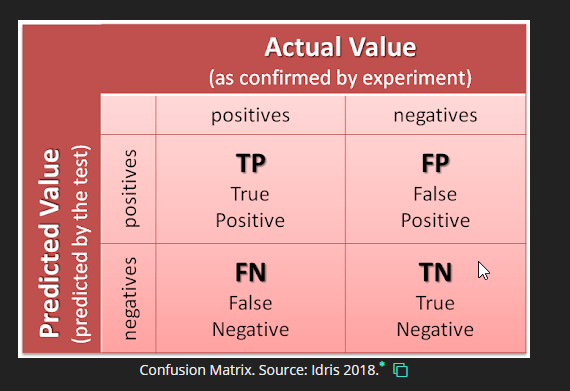

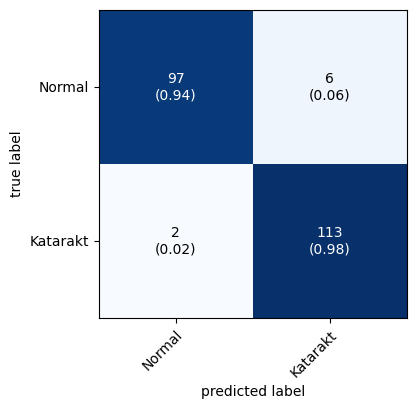

In [29]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(5,4),class_names = ["Normal","Katarakt"],
                      show_normed = True);

Matrisi yorumlayacak olursak Normal olarak sınıflandırılan 105 örneğin gerçek değerinin de normal olduğunu(True Positive) 7 tane örneğin ise gerçek değerinin  kataraktlı olmasına rağmen normal sınıfına (False Negatif) tahmin edilmiş. 106 Kataraktlı örneğin tamamı kataraktlı olarak tahmin edilmiş (True Negatif). İleride model üzerinde optimazsyon yapmak istersek normal sınıfı üzerinden yanlış tahmin edilen örnekleri gözlemleyip veriler üzerinde manipülasyon gerçekleştirerek isabet oranımızı daha da arttırabiliriz. Tahmin sonuçlarımızın doğruluğu yüksek olmasına rağmen modelin Loss ve Accuracy değerlerinin hangi epochlarda azılıp arttığını gözlemlemek istersek:

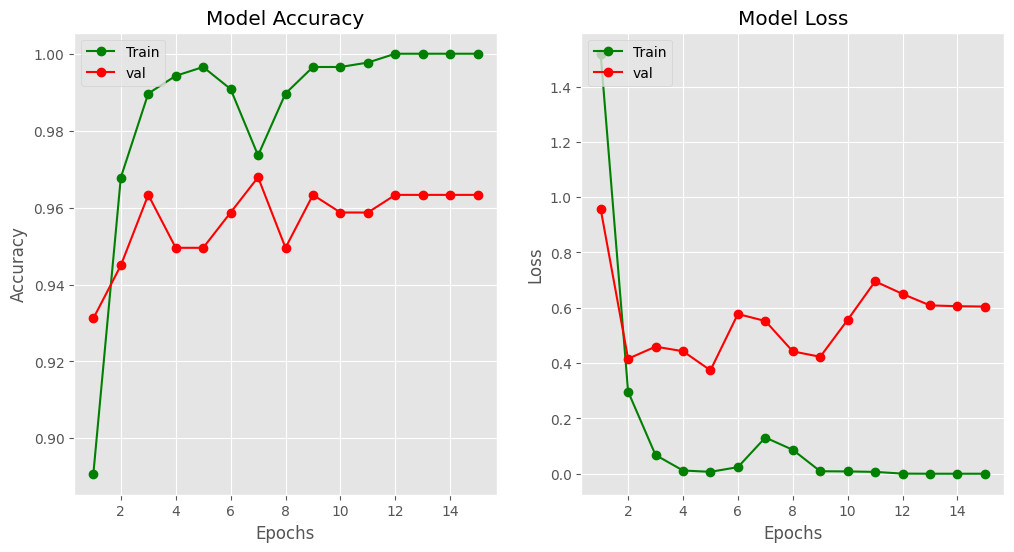

In [30]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
#Model Accuracy
plt.subplot(1,2,1)
plt.plot(epochs[:15], history.history["accuracy"][:15], "go-")
plt.plot(epochs[:15], history.history["val_accuracy"][:15], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

#Model Loss
plt.subplot(1,2,2)
plt.plot(epochs[:15], history.history["loss"][:15], "go-")
plt.plot(epochs[:15], history.history["val_loss"][:15], "ro-")

plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

Bu grafiği yorumlayacak olursak eğitim ve doğrulama verilerinin hangi epochlarda düşüp yükseldiği gösterilmektedir.Val validasyonm değeridir. Train accuracy değeri validasyon accuracy değerinden daha yüksek olduğu için yaklaşık %3'lük biz overfitting problemi olduğu söylenebilir. Aynı şekilde train loss değeri validasyon loss değerinden daha yüksek olduğu için az da olsa overfitting olduğuna varılabilir. Earlystopping, modelcheckpoint gibi overfitting önleyici metotlar dışında düzenleştirme tekniklerinin sayısını arttırmak(Dropout,L1/L2), katmanlardaki hiperparametreleri değiştirmek(Tune işlemlerinin gözden geçirilmesi),giriş verilerinin standartize edilmesi(fazla manipülasyonda ezberleme artadabilir olabildiğince raw data üzerinden çalışılmalı) gibi yöntemler takip edilebilir. Bunun yanı sıra outlier değerler drop edilebilir. Fakat ezberleme oranı çok düşük olduğu için modelimizi balance durumda sayabiliriz.

Son olarak 67. cellde değindiğimiz konfüzyon matrisindeki True Pozitif, True Negatif, False Pozitif ve False Negatif olarak labellanan görselleri rastgele olacak şekilde göstermek istersek: 

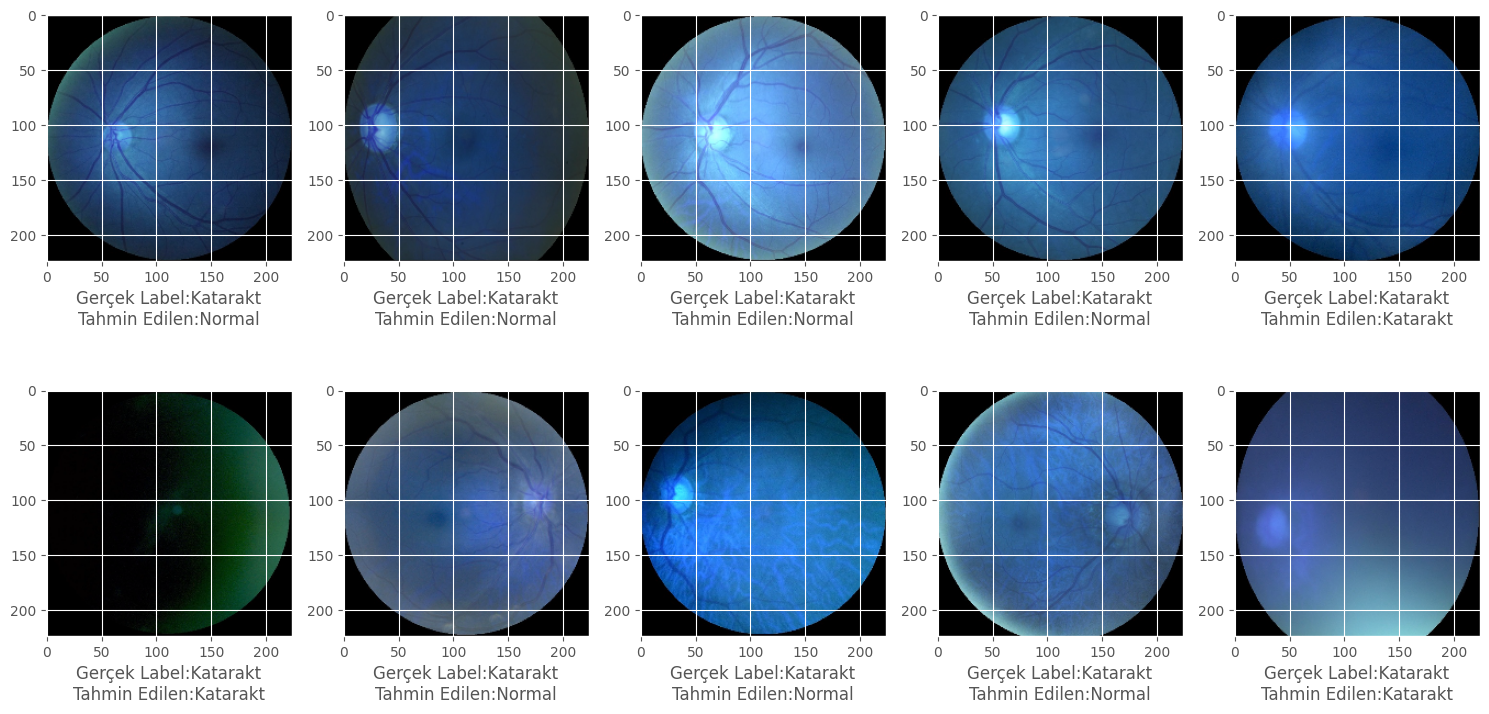

In [31]:
plt.figure(figsize=(15,8))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    ornek = x_test[sample]
    kategori = y_test[sample]
    tahmin_kategori = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Katarakt"
        
    if tahmin_kategori== 0:
        pred_label = "Normal"
    else:
        pred_label = "Katarakt"
        
    plt.subplot(2,5,i+1)
    plt.imshow(ornek)
    plt.xlabel("Gerçek Label:{}\nTahmin Edilen:{}".format(label,pred_label))
plt.tight_layout() 